In [1]:
!pip -q install pandas numpy matplotlib scikit-learn scipy tensorflow

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from scipy.signal import butter, filtfilt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF:", tf.__version__)


2025-12-16 09:21:55.473667: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 09:21:55.512061: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF: 2.20.0


2025-12-16 09:21:56.588420: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
EKG_CSV = "800_ekg.csv"
ANN_CSV = "800_annotations.csv"

assert os.path.exists(EKG_CSV), f"Missing {EKG_CSV}"
assert os.path.exists(ANN_CSV), f"Missing {ANN_CSV}"

ekg = pd.read_csv(EKG_CSV)
ann = pd.read_csv(ANN_CSV)

ekg.columns = [c.strip() for c in ekg.columns]
ann.columns = [c.strip() for c in ann.columns]

display(ekg.head())
display(ann.head())
print("ekg shape:", ekg.shape, "ann shape:", ann.shape)
print("ekg columns:", ekg.columns.tolist())
print("ann columns:", ann.columns.tolist())


,Unnamed: 0,ECG1,ECG2,annotation
0,0,-0.505,0.615,NaN
1,1,-0.495,0.755,NaN
2,2,-0.545,0.805,NaN
3,3,-0.445,0.865,NaN
4,4,-0.275,0.815,NaN


,Unnamed: 0,symbol
0,162,N
1,330,N
2,497,N
3,666,N
4,836,N


ekg shape: (230400, 4) ann shape: (1921, 2)
ekg columns: ['Unnamed: 0', 'ECG1', 'ECG2', 'annotation']
ann columns: ['Unnamed: 0', 'symbol']


In [3]:
# annotations.csv: index column + symbol column
sym_col = None
for c in ann.columns:
    if c.lower() in {"symbol", "annotation", "label"}:
        sym_col = c
        break
if sym_col is None:
    sym_col = ann.columns[-1]

idx_col = None
for c in ann.columns:
    if c == sym_col:
        continue
    if ("unnamed" in c.lower()) or ("index" in c.lower()) or ("sample" in c.lower()) or ("point" in c.lower()):
        idx_col = c
        break
if idx_col is None:
    idx_col = [c for c in ann.columns if c != sym_col][0]

ann2 = ann[[idx_col, sym_col]].rename(columns={idx_col:"sample_index", sym_col:"symbol"})
ann2["sample_index"] = ann2["sample_index"].astype(int)
ann2["symbol"] = ann2["symbol"].astype(str)

# ECG lead columns
lead_cols = [c for c in ekg.columns if c.lower() in {"ecg1","ecg2","lead1","lead2"}]
if len(lead_cols) < 2:
    candidates = [c for c in ekg.columns if not c.lower().startswith("unnamed")]
    num_candidates = [c for c in candidates if pd.api.types.is_numeric_dtype(ekg[c])]
    lead_cols = num_candidates[:2]
lead_cols = lead_cols[:2]

print("lead_cols:", lead_cols)
print("raw symbol counts:\n", ann2["symbol"].value_counts())
display(ann2.head())


lead_cols: ['ECG1', 'ECG2']
raw symbol counts:
 symbol
N    1846
S      30
~      28
|      10
V       6
F       1
Name: count, dtype: int64


,sample_index,symbol
0,162,N
1,330,N
2,497,N
3,666,N
4,836,N


In [4]:
FS = 128
PRE_S  = 0.30
POST_S = 0.50
"""
burada pre_s yi 0.30 a post_s yi n.50 yaparak tekrar sonuç alacağım
bu işlemler windowu büyüterek s/q ayrımını daha iyi yapmamı sağlayabilir.
"""

AAMI_CLASSES = ["N","S","V","F","Q"]
AAMI_TO_ID = {c:i for i,c in enumerate(AAMI_CLASSES)}

"""
def to_aami5(symbol: str) -> str:
    s = str(symbol)

    # Beat sınıfları
    if s in {"N"}: return "N"
    if s in {"S", "A", "a", "J"}: return "S"   # supraventricular family
    if s in {"V", "E"}: return "V"             # ventricular family
    if s in {"F"}: return "F"

    # Senin isteğin:
    if s in {"~", "|"}: return "Q"

    # Bilinmeyen ne gelirse Q
    return "Q"
"""
# AAMI de f sınıfı sadece 1 örnek olduğu için (stratify=y) dağıtım yapamıyor bu yüzden least populated class has only 1 member hatası verdi
# F yi bu aşaama tek olduğu için Q ya katacağız ama normalde tüm dataset kullandğımızda bu problem yaşamayacağız.

def to_aami5(symbol: str) -> str:
    s = str(symbol)

    if s in {"N"}: return "N"
    if s in {"S", "A", "a", "J"}: return "S"
    if s in {"V", "E"}: return "V"

    # BU RECORD İÇİN: F çok az (1 tane) => Q'ya katıyoruz
    if s in {"F"}: return "Q"

    if s in {"~", "|"}: return "Q"
    return "Q"



In [5]:
def bandpass(x, fs, low=0.5, high=40.0, order=4):
    ny = 0.5 * fs
    b, a = butter(order, [low/ny, high/ny], btype="band")
    return filtfilt(b, a, x)

def make_windows(ekg_df, ann_df, lead_cols, fs, pre_s, post_s):
    sig = ekg_df[lead_cols].values.astype(np.float32)

    # filtre
    sig_f = np.zeros_like(sig)
    for ch in range(sig.shape[1]):
        sig_f[:, ch] = bandpass(sig[:, ch], fs=fs)

    a = ann_df.copy().sort_values("sample_index")

    pre  = int(round(pre_s * fs))
    post = int(round(post_s * fs))
    L = pre + post + 1

    idx = a["sample_index"].values

    rr_prev = np.diff(idx, prepend=idx[0]).astype(np.float32) / fs
    rr_next = np.diff(idx, append=idx[-1]).astype(np.float32) / fs
    rr_ratio = np.divide(rr_prev, rr_next, out=np.ones_like(rr_prev), where=rr_next!=0)

    X, R, sym = [], [], []
    for i, sidx in enumerate(idx):
        start = sidx - pre
        end   = sidx + post
        if start < 0 or end >= len(sig_f):
            continue
        X.append(sig_f[start:end+1, :])
        R.append([rr_prev[i], rr_next[i], rr_ratio[i]])
        sym.append(a.iloc[i]["symbol"])

    X = np.stack(X).astype(np.float32)
    R = np.array(R, dtype=np.float32)
    sym = np.array(sym)
    return X, R, sym, L

X, R, sym_raw, L = make_windows(ekg, ann2, lead_cols, FS, PRE_S, POST_S)

y_aami = np.array([to_aami5(s) for s in sym_raw])
y = np.array([AAMI_TO_ID[c] for c in y_aami], dtype=np.int32)

print("X:", X.shape, "R:", R.shape, "L:", L)
print("AAMI counts:\n", pd.Series(y_aami).value_counts())
print("Class IDs:\n", pd.Series(y).value_counts().sort_index())


X: (1921, 91, 2) R: (1921, 3) L: 91
AAMI counts:
 N    1846
Q      39
S      30
V       6
Name: count, dtype: int64
Class IDs:
 0    1846
1      30
2       6
4      39
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

# Artık sınıflar: N / S / V / Q
AAMI_CLASSES = ["N", "S", "V", "Q"]
AAMI_TO_ID = {c:i for i,c in enumerate(AAMI_CLASSES)}

# y_aami içinden sadece bu sınıflar olmalı (N,S,V,Q)
print("Unique AAMI labels:", sorted(pd.Series(y_aami).unique()))

# Yeniden ID'le: 0..3
y = np.array([AAMI_TO_ID[c] for c in y_aami], dtype=np.int32)

print("4-class IDs:\n", pd.Series(y).value_counts().sort_index())

X_train, X_tmp, R_train, R_tmp, y_train, y_tmp = train_test_split(
    X, R, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, R_val, R_test, y_val, y_test = train_test_split(
    X_tmp, R_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp
)

def count_classes(arr):
    return pd.Series(arr).value_counts().sort_index()

print("Train counts:\n", count_classes(y_train))
print("Val counts:\n", count_classes(y_val))
print("Test counts:\n", count_classes(y_test))


Unique AAMI labels: ['N', 'Q', 'S', 'V']
4-class IDs:
 0    1846
1      30
2       6
3      39
Name: count, dtype: int64
Train counts:
 0    1292
1      21
2       4
3      27
Name: count, dtype: int64
Val counts:
 0    277
1      4
2      1
3      6
Name: count, dtype: int64
Test counts:
 0    277
1      5
2      1
3      6
Name: count, dtype: int64


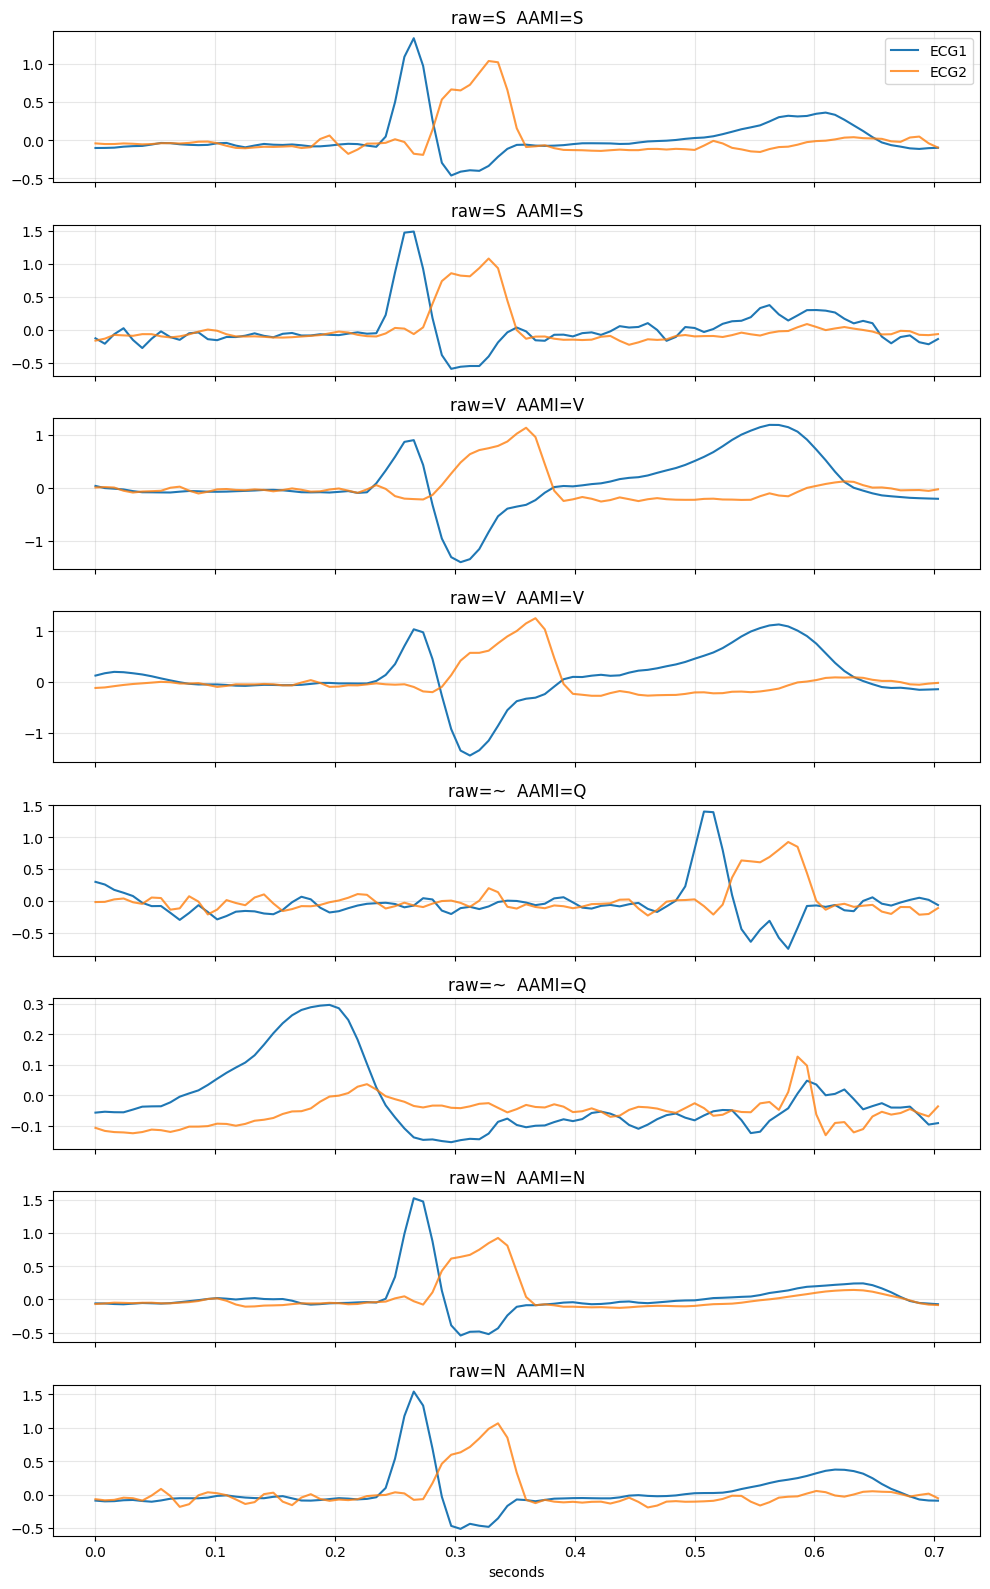

In [7]:
# Q, S, V gibi az sınıflardan birkaç örnek çizelim
def pick_examples(label, k=3):
    idxs = np.where(y_aami == label)[0]
    if len(idxs) == 0:
        return []
    rng = np.random.default_rng(0)
    return rng.choice(idxs, size=min(k, len(idxs)), replace=False)

labels_to_show = ["S","V","F","Q","N"]
t = np.arange(L) / FS

chosen = []
for lab in labels_to_show:
    chosen += list(pick_examples(lab, k=2))

if len(chosen) == 0:
    print("No examples to plot.")
else:
    fig, axes = plt.subplots(len(chosen), 1, figsize=(10, 2*len(chosen)), sharex=True)
    if len(chosen) == 1: axes = [axes]
    for ax, i in zip(axes, chosen):
        ax.plot(t, X[i,:,0], label=lead_cols[0])
        ax.plot(t, X[i,:,1], label=lead_cols[1], alpha=0.8)
        ax.set_title(f"raw={sym_raw[i]}  AAMI={y_aami[i]}")
        ax.grid(True, alpha=0.3)
    axes[0].legend(loc="upper right")
    plt.xlabel("seconds")
    plt.tight_layout()
    plt.show()


In [8]:
X_train, X_tmp, R_train, R_tmp, y_train, y_tmp = train_test_split(
    X, R, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, R_val, R_test, y_val, y_test = train_test_split(
    X_tmp, R_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp
)

def count_classes(arr):
    s = pd.Series(arr).value_counts().sort_index()
    return s

print("Train class counts:\n", count_classes(y_train))
print("Val   class counts:\n", count_classes(y_val))
print("Test  class counts:\n", count_classes(y_test))


Train class counts:
 0    1292
1      21
2       4
3      27
Name: count, dtype: int64
Val   class counts:
 0    277
1      4
2      1
3      6
Name: count, dtype: int64
Test  class counts:
 0    277
1      5
2      1
3      6
Name: count, dtype: int64


In [9]:
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}

print("class_weight:", class_weight)


class_weight: {0: 0.26006191950464397, 1: 16.0, 2: 84.0, 3: 12.444444444444445}


In [10]:
"""def build_cnn_with_rr_multiclass(input_len, n_channels=2, n_classes=5):
    x_in = keras.Input(shape=(input_len, n_channels), name="signal")
    x = layers.Conv1D(32, 7, padding="same", activation="relu")(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)

    rr_in = keras.Input(shape=(3,), name="rr")
    r = layers.Dense(16, activation="relu")(rr_in)
    r = layers.Dropout(0.2)(r)

    h = layers.Concatenate()([x, r])
    h = layers.Dense(64, activation="relu")(h)
    h = layers.Dropout(0.3)(h)

    out = layers.Dense(n_classes, activation="softmax")(h)

    model = keras.Model(inputs=[x_in, rr_in], outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )
    return model

model = build_cnn_with_rr_multiclass(input_len=L, n_channels=2, n_classes=5)
model.summary()
""" 
# bu üstteki cnn rr modeli 5 sınıflıya göre fakat biz f sınıfını yok saydığımız için daha doğrusu diğerinin içine kattığımız için çok ufak değişiklikler oldu.
def build_cnn_with_rr_multiclass(input_len, n_channels=2, n_classes=4):
    x_in = keras.Input(shape=(input_len, n_channels), name="signal")

    x = layers.Conv1D(32, 7, padding="same", activation="relu")(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)

    rr_in = keras.Input(shape=(3,), name="rr")
    r = layers.Dense(16, activation="relu")(rr_in)
    r = layers.Dropout(0.2)(r)

    h = layers.Concatenate()([x, r])
    h = layers.Dense(64, activation="relu")(h)
    h = layers.Dropout(0.3)(h)

    out = layers.Dense(n_classes, activation="softmax")(h)

    model = keras.Model(inputs=[x_in, rr_in], outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )
    return model

model = build_cnn_with_rr_multiclass(input_len=L, n_channels=2, n_classes=len(AAMI_CLASSES))
model.summary()

2025-12-16 09:21:57.709495: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signal (InputLayer) │ (None, 91, 2)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 91, 32)    │        480 │ signal[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 91, 32)    │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 45, 32)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 45, 64)    │     10,304 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 22, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 22, 128)   │     24,704 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rr (InputLayer)     │ (None, 3)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         64 │ rr[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 144)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      9,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        260 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,988 (179.64 KB)

 Trainable params: 45,540 (177.89 KB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
"""
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_acc", mode="max", patience=4, factor=0.5, min_lr=1e-5),
]

history = model.fit(
    {"signal": X_train, "rr": R_train}, y_train,
    validation_data=({"signal": X_val, "rr": R_val}, y_val),
    epochs=50,
    batch_size=64,
    class_weight=class_weight,
    verbose=1
)
"""


callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", mode="min", patience=4, factor=0.5, min_lr=1e-5),
]

history = model.fit(
    {"signal": X_train, "rr": R_train}, y_train,
    validation_data=({"signal": X_val, "rr": R_val}, y_val),
    epochs=50,
    batch_size=64,
    class_weight=class_weight,
    verbose=1
)



Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - acc: 0.4033 - loss: 1.2631 - val_acc: 0.0208 - val_loss: 1.3054
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.4688 - loss: 0.9443 - val_acc: 0.0729 - val_loss: 1.1544
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.5692 - loss: 0.6578 - val_acc: 0.5347 - val_loss: 1.0129
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.6704 - loss: 0.5215 - val_acc: 0.2431 - val_loss: 0.9592
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.7299 - loss: 0.5367 - val_acc: 0.0208 - val_loss: 1.0539
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.7656 - loss: 0.4052 - val_acc: 0.0208 - val_loss: 1.1785
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.7798 - loss: 0.3660 - val_acc: 0.0208 - val_loss: 1.3798
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.8289 - loss: 0.3018 - val_acc: 0.0208 - val_loss: 1.6036
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8705

In [12]:
from sklearn.metrics import f1_score

proba = model.predict({"signal": X_test, "rr": R_test})
y_pred = np.argmax(proba, axis=1)

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=AAMI_CLASSES, digits=4, zero_division=0))

macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
weighted_f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
print("Macro-F1   :", macro_f1)
print("Weighted-F1:", weighted_f1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Classification report:
              precision    recall  f1-score   support

           N     0.9928    0.9892    0.9910       277
           S     0.6667    0.8000    0.7273         5
           V     1.0000    1.0000    1.0000         1
           Q     0.8333    0.8333    0.8333         6

    accuracy                         0.9827       289
   macro avg     0.8732    0.9056    0.8879       289
weighted avg     0.9838    0.9827    0.9832       289

Macro-F1   : 0.8878911173214971
Weighted-F1: 0.9831551655387668


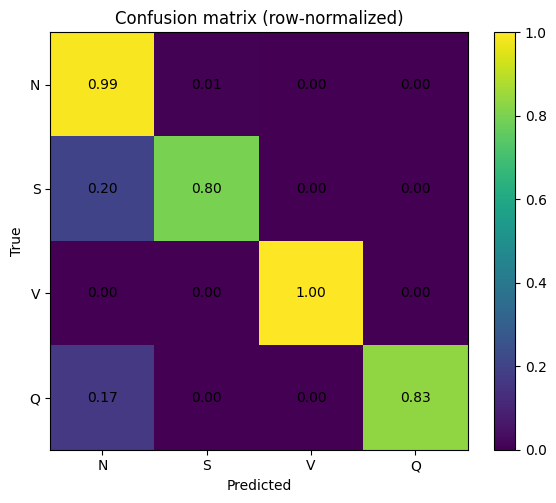

In [13]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix (row-normalized)")
plt.xticks(range(len(AAMI_CLASSES)), AAMI_CLASSES)
plt.yticks(range(len(AAMI_CLASSES)), AAMI_CLASSES)
plt.colorbar()
plt.xlabel("Predicted"); plt.ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i,j]:.2f}", ha="center", va="center")

plt.tight_layout()
plt.show()
